<h1>BATTLE OF THE NEIGHBORHOODS</h1>
<h2>Finding the best district location in Lima Metropolitan Area using Data Science </h2>


## Introduction
This project aims to use the data science concepts learned in the IBM Data Science Professional Certification. We define a Business Problem, the data obtained will be analysed using Machine Learning tools. In this project, we will go through all the processes step by step from problem design, data preparation to final analysis and finally provide a conclusion that business stakeholders can leverage to make their decisions.



## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1. Download and Explore Dataset


2. Explore and Analyze: Clustered population density map of Lima Metropolitan with districts


3. Explore and Analyze: Foursquare API & Machine learning – K-Means

    3.1. Cluster Districts 
    
    3.2. Examine Clusters

</font>
</div>


## 1. Download and Explore Dataset

#### Install and import libraries.

In [1]:
#Install libraries
# libraries
import pandas as pd
from pandas.io.json import json_normalize  # tranform JSON file into a pandas dataframe

# install beautifulsoup4
!pip install beautifulsoup4
from bs4 import BeautifulSoup

import requests

import numpy as np

# install geopy
!pip install geopy 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# map rendering library
import folium 

# install scikit-learn and import k-means from clustering sta
!pip install -U scikit-learn 
from sklearn.cluster import KMeans

# Matplotlib and associated plotting modules
import matplotlib
import matplotlib.cm as cm 
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
from IPython.display import display_html

Requirement already up-to-date: scikit-learn in c:\users\hogar\appdata\local\programs\arcgis\pro\bin\python\envs\arcgispro-py3\lib\site-packages (0.24.2)


#### Load and explore the data.

Lima province.

In [2]:
#Lima province
# Using Wikipedia page data with requests
data = requests.get('https://es.wikipedia.org/wiki/Anexo:Distritos_de_Lima').text

# Parsing data using BeautifulSoup
soup = BeautifulSoup(data, 'html.parser')

# Initiating lists that used dataframe
district = []
ubigeo =[]
area = []
poblacion = []

# looking for any tables on the Wikipedia page
soup.find('table').find_all('tr')

for row in soup.find('table').find_all('tr'):
    cells = row.find_all('td')
    
# looking for the necessary information we need to create our dataframe
for row in soup.find('table').find_all('tr'):
    cells = row.find_all('td')
    if(len(cells) > 0):
        district.append(cells[0].text.rstrip('\n'))
        ubigeo.append(cells[1].text)
        area.append(cells[2].text.rstrip('\n'))
        poblacion.append(cells[3].text.rstrip('\n'))

In [3]:
# creating the dataframe with the columns we want using pandas
lima_data = pd.DataFrame({"District": district,
                          "Area_km2": area,
                        "Population": poblacion})

# Rename district Villa El Salvador
lima_data['District'] = lima_data['District'].replace(['Villa El Salvador'],'Villa el Salvador')

lima_data.tail()

,District,Area_km2,Population
38,Santa Rosa,21.5,27 863
39,Santiago de Surco,34.75,329 152
40,Surquillo,3.46,91 023
41,Villa el Salvador,35.46,393 254
42,Villa María del Triunfo,70.57,398 433


Callao province.

In [4]:
#Callao province
# Using Wikipedia page data with requests
datac = requests.get('https://es.wikipedia.org/wiki/Anexo:Distritos_del_Callao').text

# Parsing data using BeautifulSoup
soup = BeautifulSoup(datac, 'html.parser')

# Initiating lists that used dataframe
district =[]
ubigeo = []
area = []
population = []

# looking for any tables on the Wikipedia page
soup.find('table').find_all('tr')

for row in soup.find('table').find_all('tr'):
    cells = row.find_all('td')
    
# looking for the necessary information we need to create our dataframe
for row in soup.find('table').find_all('tr'):
    cells = row.find_all('td')
    if(len(cells) > 0):
        district.append(cells[0].text.rstrip('\n')) 
        ubigeo.append(cells[1].text.rstrip('\n'))
        area.append(cells[2].text.rstrip('\n'))
        population.append(cells[3].text.rstrip('\n'))

In [5]:
# creating the dataframe with the columns we want using pandas
callao_data = pd.DataFrame({
                            "District": ubigeo,
                            "Area_km2": area,
                            "Population": population})

# Rename district Carmen de La Legua-Reynoso
callao_data['District'] = callao_data['District'].replace(['Carmen de La Legua-Reynoso'],'Carmen de la Legua Reynoso')

callao_data

,District,Area_km2,Population
0,Callao,45.65,451 260
1,Bellavista,4.56,74 851
2,Carmen de la Legua Reynoso,2.12,42 240
3,La Perla,2.75,61 417
4,La Punta,0.75,3 829
5,Ventanilla,73.52,315 600
6,Mi Perú,2.47,45 297


In [6]:
#Cleaning dataframe callao
#Replace coma by punto 
callao_data["Area_km2"].str.replace(',', '.')
callao_data.head()

,District,Area_km2,Population
0,Callao,45.65,451 260
1,Bellavista,4.56,74 851
2,Carmen de la Legua Reynoso,2.12,42 240
3,La Perla,2.75,61 417
4,La Punta,0.75,3 829


#### Merge the districts of the province of Lima and Callao to obtain the Lima Metropolitan Area.

In [7]:
#Merging two dataframes vertically and reset index
df_ciudad = lima_data.append(callao_data).reset_index(drop=True)

df_ciudad.tail(15)

,District,Area_km2,Population
35,San Miguel,10.72,155 384
36,Santa Anita,10.69,196 214
37,Santa María del Mar,9.81,999
38,Santa Rosa,21.5,27 863
39,Santiago de Surco,34.75,329 152
40,Surquillo,3.46,91 023
41,Villa el Salvador,35.46,393 254
42,Villa María del Triunfo,70.57,398 433
43,Callao,45.65,451 260
44,Bellavista,4.56,74 851


#### Create the column "Density" and calculate its value.

In [8]:
#Calculating density

#Changing type of data object to int64 - First number
df_ciudad["Area_km2"] = pd.to_numeric(df_ciudad["Area_km2"])

#Replace white spaces on Population row
df_ciudad["Population"] = df_ciudad["Population"].replace(' ', '', regex=True)

#Changing type of data object to int64 - Second number
df_ciudad["Population"] = pd.to_numeric(df_ciudad["Population"])

#Density person/km2
df_ciudad['Density'] = df_ciudad['Population'].div(df_ciudad['Area_km2'].shift(0))

df_ciudad


,District,Area_km2,Population,Density
0,Ancón,299.22,62928,210.306798
1,Ate Vitarte,77.72,599196,7709.675759
2,Barranco,3.33,34378,10323.723724
3,Breña,3.22,85309,26493.478261
4,Carabayllo,346.88,333045,960.115890
5,Chaclacayo,39.50,42912,1086.379747
6,Chorrillos,38.94,314241,8069.876733
7,Cieneguilla,240.33,34684,144.318229
8,Comas,48.75,520450,10675.897436
9,El Agustino,12.54,198862,15858.213716


#### Importing from CSV the latitude and longitude values of Lima Metropolitan Area´ districts.

In [9]:
# Importing the csv file conatining the latitudes/longitudes 
url = 'https://raw.githubusercontent.com/Will5678/Coursera_Capstone/main/TareaFinal_Geospatial_Coordinates.csv?raw=true'
ciudad_coord = pd.read_csv(url, encoding = "utf-8-sig")

# Rename district Carmen de la Legua. In the CSV it says a wrong district 
ciudad_coord['District'] = ciudad_coord['District'].replace(['Carmen de la Legua'],'Carmen de la Legua Reynoso')

ciudad_coord

,District,Latitude,Longitude
0,Ancón,-11.773878,-77.175335
1,Ate Vitarte,-12.027778,-76.916667
2,Barranco,-12.141667,-77.016667
3,Bellavista,-12.062391,-77.128628
4,Breña,-12.059160,-77.050590
5,Callao,-12.052263,-77.139113
6,Carabayllo,-11.839100,-77.033700
7,Carmen de la Legua Reynoso,-12.039444,-77.095278
8,Chaclacayo,-11.983333,-76.766667
9,Chorrillos,-12.186389,-77.021111


#### Merge the dataframe Latitude&Longitude and Districts.

In [10]:
# Merging the tables: the Latitudes/Longitudes and districts
dftotal_ciudad= pd.merge( ciudad_coord,df_ciudad,on = 'District')

# Changing the order of DataFrame columns
dftotal_ciudad = dftotal_ciudad[['District','Population','Area_km2','Density',' Latitude',' Longitude']]

dftotal_ciudad.head()


,District,Population,Area_km2,Density,Latitude,Longitude
0,Ancón,62928,299.22,210.306798,-11.773878,-77.175335
1,Ate Vitarte,599196,77.72,7709.675759,-12.027778,-76.916667
2,Barranco,34378,3.33,10323.723724,-12.141667,-77.016667
3,Bellavista,74851,4.56,16414.692982,-12.062391,-77.128628
4,Breña,85309,3.22,26493.478261,-12.059160,-77.050590


#### Create a map of Lima Metropolitan Area with districts superimposed on top.

In [11]:
# Getting the latitude/longitude of Lima Province
address = "Lima Province"

geolocator = Nominatim(user_agent="my_application")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Lima city are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Lima city are -12.0621065, -77.0365256.


In [12]:

# Creating map of Lima Metropolitan city using latitude/longitude values
map_limacity = folium.Map(location=[latitude,longitude],zoom_start=9)

# adding in the markers for Lima Metropolitan city
for lat, lng, district, density in zip(
            dftotal_ciudad[" Latitude"],
            dftotal_ciudad[" Longitude"],
            dftotal_ciudad["District"],
            dftotal_ciudad["Density"],):
    label = "Distrito: {}, Densidad: {} hab/km2".format(district, density)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat,lng],
        radius=4,
        popup=label,
        color="blue",
        fill=True,
        fill_color="#3186cc",
        fill_opacity=0.7,
        parse_html=False).add_to(map_limacity)
       
map_limacity

#### Create bar chart "Population density of Lima Metropolitan's district per square kilometer (inhab/km2).

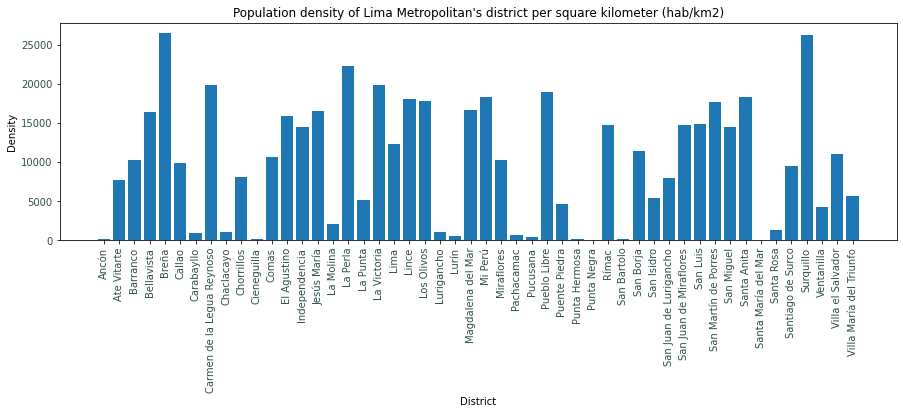

In [13]:
#Bar Chart Matplot
dftotal_sortdensity = dftotal_ciudad.sort_values("Density")

# Increase the width
plt.figure(figsize=(15,4))
# To create a bar graph use bar function of pyplot
plt.bar(dftotal_ciudad["District"],dftotal_ciudad["Density"])
# Rotate the name of sports by 90 degree in x-axis
plt.xticks(rotation=90, color="darkslategray")
plt.yticks(rotation=0, color="darkslategray")
#Set descriptions:
plt.title("Population density of Lima Metropolitan's district per square kilometer (hab/km2)")
plt.ylabel('Density', color ="black")
plt.xlabel('District', color = "black")

# show the graph 
plt.show()

## 2. Explore and Analyze: Clustered population density map of Lima Metropolitan with districts

#### Create a llst of conditions to add clusters.

In [14]:
# create a list of our conditions
conditions = [
    (dftotal_ciudad['Density'] <= 2950),
    (dftotal_ciudad['Density'] > 2950) & (dftotal_ciudad['Density'] <= 5900),
    (dftotal_ciudad['Density'] > 5900) & (dftotal_ciudad['Density'] <= 8850),
    (dftotal_ciudad['Density'] > 8850) & (dftotal_ciudad['Density'] <= 11800),
    (dftotal_ciudad['Density'] > 11800) & (dftotal_ciudad['Density'] <= 14750),
    (dftotal_ciudad['Density'] > 14750) & (dftotal_ciudad['Density'] <= 17700),
    (dftotal_ciudad['Density'] > 17700) & (dftotal_ciudad['Density'] <= 20650),
    (dftotal_ciudad['Density'] > 20650) & (dftotal_ciudad['Density'] <= 23600),
    (dftotal_ciudad['Density'] > 23600)
    ]

# create a list of the values we want to assign for each condition
values = [1, 2, 3, 4, 5, 6, 7, 8, 9]

# Creating a new column Densities and use np.select to assign values to it using our lists as arguments
dftotal_ciudad['Densities'] = np.select(conditions, values)

# display updated DataFrame
dftotal_ciudad.head()

,District,Population,Area_km2,Density,Latitude,Longitude,Densities
0,Ancón,62928,299.22,210.306798,-11.773878,-77.175335,1
1,Ate Vitarte,599196,77.72,7709.675759,-12.027778,-76.916667,3
2,Barranco,34378,3.33,10323.723724,-12.141667,-77.016667,4
3,Bellavista,74851,4.56,16414.692982,-12.062391,-77.128628,6
4,Breña,85309,3.22,26493.478261,-12.059160,-77.050590,9


####  Create a densities map of Lima Metropolitan Area with districts superimposed on top.

In [15]:
#Se usa "clusters" porque se ha copiado de otro, 9 is the options
clusters = 9

# Creating map
map_densities = folium.Map(location=[latitude, longitude], zoom_start=9)

# Set color scheme for the clusters
x = np.arange(clusters)
ys = [i + x + (i*x)**2 for i in range(clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Adding markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(
        dftotal_ciudad[' Latitude'], 
        dftotal_ciudad[' Longitude'], 
        dftotal_ciudad['District'], 
        dftotal_ciudad['Densities']):
    label = folium.Popup(" El distrito "+ str(poi) +" tiene densidad de: " + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_densities)
       
map_densities

#### Add legend to clusters density map.

In [16]:
#Importing branca for legend
from branca.element import Template, MacroElement

template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
     
<div class='legend-title'>Legend</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:red;opacity:0.7;'></span>9 Major density</li>
    <li><span style='background:orangered;opacity:0.7;'></span>8</li>
    <li><span style='background:orange;opacity:0.7;'></span>7</li>
    <li><span style='background:lightgreen;opacity:0.7;'></span>6</li>
    <li><span style='background:aquamarine;opacity:0.7;'></span>5 Middle density</li>
    <li><span style='background:cyan;opacity:0.7;'></span>4</li>
    <li><span style='background:dodgerblue;opacity:0.7;'></span>3</li>
    <li><span style='background:mediumblue;opacity:0.7;'></span>2</li>
    <li><span style='background:darkorchid;opacity:0.7;'></span>1 Minor density</li>

  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

macro = MacroElement()
macro._template = Template(template)

map_densities.get_root().add_child(macro)

map_densities

## 3. Explore and Analyze: Machine learning – K-Means

#### Define Foursquare Credentials and Version.

In [17]:
#Generate Foursquare conection
CLIENT_ID = '40NILBPPO50ZRI5NLFXRLXJOFM2VVIGPK4GZ15EPQULLFATR' # your Foursquare ID
CLIENT_SECRET = 'NZRHTX2GIN0QK5AWM2W1DTIBMUMKBW1ZEIUTKXTU5SN4QJZI' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 40NILBPPO50ZRI5NLFXRLXJOFM2VVIGPK4GZ15EPQULLFATR
CLIENT_SECRET:NZRHTX2GIN0QK5AWM2W1DTIBMUMKBW1ZEIUTKXTU5SN4QJZI


#### Explore districts in our dataframe.

Create function for getting the venues nearby districts.

In [18]:
# Function for getting the venues nearby 
def getNearbyVenues(names, latitudes, longitudes, radius=4000):
    venues_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        # print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Write the code to run the above function on each districts and create a new dataframe called city_venues.

In [19]:
# Function to get venues nearby for each district
city_venues = getNearbyVenues(names=dftotal_ciudad['District'],
                                   latitudes=dftotal_ciudad[' Latitude'],
                                   longitudes=dftotal_ciudad[' Longitude']
                                  )
print(city_venues.shape)
city_venues.head()

(3338, 7)


,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Ancón,-11.773878,-77.175335,Playa Hermosa,-11.774645,-77.186379,Beach
1,Ancón,-11.773878,-77.175335,Yatch Club Ancon,-11.774722,-77.183791,Beach
2,Ancón,-11.773878,-77.175335,Club FAP Ancon,-11.770104,-77.172772,Beach
3,Ancón,-11.773878,-77.175335,Balneario Santa Rosa,-11.796500,-77.169335,Beach
4,Ancón,-11.773878,-77.175335,Balneario de la Marina - Sede Ancón,-11.779189,-77.194937,Beach


Check how many venues were returned for each districts.

In [20]:
# Group by district
city_venues.groupby('District').count()

,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
District,,,,,,
Ancón,17,17,17,17,17,17
Ate Vitarte,48,48,48,48,48,48
Barranco,100,100,100,100,100,100
Bellavista,100,100,100,100,100,100
Breña,100,100,100,100,100,100
Callao,88,88,88,88,88,88
Carabayllo,4,4,4,4,4,4
Carmen de la Legua Reynoso,100,100,100,100,100,100
Chaclacayo,28,28,28,28,28,28


#### Find out how many unique categories can be curated from all the returned venues.

In [21]:
# Print the number of distinct categories
print('There are {} uniques categories.'.format(len(city_venues['Venue Category'].unique())))

There are 221 uniques categories.


#### Create One-hot encoding for analyze each districts. 

In [22]:
# One hot encoding
city_onehot = pd.get_dummies(city_venues[['Venue Category']], prefix="", prefix_sep="")

# Add district column back to dataframe
city_onehot['District'] = city_venues['District'] 

# Move district column to first column
fix_column = [city_onehot.columns[-1]] + list(city_onehot.columns[:-1])
city_onehot = city_onehot[fix_column]

city_onehot.head()

,District,Accessories Store,Airport,Airport Lounge,Airport Service,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Entertainment,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Water Park,Wine Bar,Wings Joint,Yoga Studio,Zoo
0,Ancón,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Ancón,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Ancón,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Ancón,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Ancón,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Examine the new dataframe size

In [23]:
city_onehot.shape

(3338, 222)

#### Group rows by Districts and by taking the mean of the frequency of occurrence of each category.

In [24]:
#Create dataframe where venues are grouped by frequency for each Neighborhood
city_grouped = city_onehot.groupby('District').mean().reset_index()
city_grouped.head()

,District,Accessories Store,Airport,Airport Lounge,Airport Service,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Entertainment,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Water Park,Wine Bar,Wings Joint,Yoga Studio,Zoo
0,Ancón,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,...,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.000000
1,Ate Vitarte,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,...,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.020833
2,Barranco,0.0,0.0,0.0,0.0,0.01,0.01,0.01,0.02,0.0,...,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.02,0.000000
3,Bellavista,0.0,0.0,0.0,0.0,0.00,0.00,0.02,0.00,0.0,...,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.000000
4,Breña,0.0,0.0,0.0,0.0,0.01,0.00,0.02,0.01,0.0,...,0.0,0.0,0.01,0.0,0.0,0.01,0.0,0.0,0.00,0.000000


#### Print each districts along with the top 20 most common venues.

In [25]:
num_top_venues = 20

for hood in city_grouped['District']:
    print("----"+hood+"----")
    temp = city_grouped[city_grouped['District'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Ancón----
                            venue  freq
0                           Beach  0.59
1              Seafood Restaurant  0.12
2                 Harbor / Marina  0.06
3                            Park  0.06
4             Peruvian Restaurant  0.06
5                    Dessert Shop  0.06
6                           Plaza  0.06
7                      Nail Salon  0.00
8                 Nature Preserve  0.00
9                    Neighborhood  0.00
10                      Nightclub  0.00
11          Outdoors & Recreation  0.00
12                     Non-Profit  0.00
13                    Music Venue  0.00
14                         Office  0.00
15                Organic Grocery  0.00
16           Other Great Outdoors  0.00
17              Accessories Store  0.00
18  Paper / Office Supplies Store  0.00
19                   Outlet Store  0.00


----Ate Vitarte----
                     venue  freq
0               Restaurant  0.10
1            Grocery Store  0.08
2            Shopping Mal

Write a function to sort the venues in descending order. 

In [26]:
# Function to retrieve 20 most common venues for each District
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]


Create the new dataframe and display the top 20 venues for each districts.

In [27]:
# Function to retrieve 20 most common venues for each District
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 20

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
district_vsorted = pd.DataFrame(columns=columns)
district_vsorted['District'] = city_grouped['District']

for ind in np.arange(city_grouped.shape[0]):
    district_vsorted.iloc[ind, 1:] = return_most_common_venues(city_grouped.iloc[ind, :], num_top_venues)

district_vsorted

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,...,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
0,Ancón,Beach,Seafood Restaurant,Harbor / Marina,Park,Peruvian Restaurant,Dessert Shop,Plaza,Fish Market,Flea Market,...,Fish & Chips Shop,Flower Shop,Field,Fast Food Restaurant,Farmers Market,Farm,Zoo,Donut Shop,Electronics Store,Food & Drink Shop
1,Ate Vitarte,Restaurant,Shopping Mall,Grocery Store,Soccer Stadium,Seafood Restaurant,Peruvian Restaurant,Bar,Steakhouse,Fried Chicken Joint,...,Donut Shop,Burger Joint,Zoo,Park,Field,Farm,Multiplex,Farmers Market,Fast Food Restaurant,Furniture / Home Store
2,Barranco,Park,Peruvian Restaurant,Hotel,Coffee Shop,Seafood Restaurant,Gym / Fitness Center,Restaurant,Bar,Bakery,...,Italian Restaurant,Supermarket,Nightclub,Mediterranean Restaurant,Japanese Restaurant,Yoga Studio,Sandwich Place,Gourmet Shop,Organic Grocery,Ice Cream Shop
3,Bellavista,Seafood Restaurant,Chinese Restaurant,Bakery,Fried Chicken Joint,Peruvian Restaurant,Coffee Shop,Ice Cream Shop,Beach,Fast Food Restaurant,...,Restaurant,Juice Bar,Donut Shop,Park,Café,Shopping Mall,Gym,Art Gallery,BBQ Joint,Asian Restaurant
4,Breña,Bakery,Sandwich Place,Peruvian Restaurant,Theater,Plaza,Coffee Shop,Café,Chinese Restaurant,Restaurant,...,Dessert Shop,Park,Pizza Place,Ice Cream Shop,Art Gallery,Italian Restaurant,History Museum,Steakhouse,Playground,Pool
5,Callao,Seafood Restaurant,Peruvian Restaurant,Harbor / Marina,Plaza,Bakery,Beach,Restaurant,Chinese Restaurant,Fried Chicken Joint,...,Fast Food Restaurant,Scenic Lookout,Coffee Shop,Boat or Ferry,Shopping Mall,Café,BBQ Joint,Gym,Art Gallery,Military Base
6,Carabayllo,History Museum,Peruvian Restaurant,Soccer Field,Neighborhood,Zoo,Exhibit,Food,Flower Shop,Flea Market,...,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market,Farm,Electronics Store,Food Court,Donut Shop,Dog Run,Dive Bar
7,Carmen de la Legua Reynoso,Seafood Restaurant,Coffee Shop,Peruvian Restaurant,Chinese Restaurant,Park,Restaurant,Ice Cream Shop,Bakery,Pizza Place,...,Fried Chicken Joint,Airport,Shopping Mall,Italian Restaurant,Hotel,Sandwich Place,Donut Shop,Mexican Restaurant,Cantonese Restaurant,Department Store
8,Chaclacayo,Campground,Restaurant,Peruvian Restaurant,Bakery,Field,Dessert Shop,Food,Flea Market,Burger Joint,...,Market,Café,Bed & Breakfast,Golf Course,Grocery Store,Hotel,Pizza Place,Park,Pool,Snack Place
9,Chorrillos,Seafood Restaurant,Restaurant,Bar,Peruvian Restaurant,Ice Cream Shop,Fried Chicken Joint,Burger Joint,Coffee Shop,Performing Arts Venue,...,Beach,Scenic Lookout,Sandwich Place,Public Art,Museum,Wings Joint,Mediterranean Restaurant,Gym,Grocery Store,Café


### 3.1. Cluster Districts 

#### Run k-means to cluster the districs into 5 clusters.

In [28]:
# Set number of clusters
kclusters = 5

city_grouped_clustering = city_grouped.drop('District', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(city_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 3, 1, 3, 1, 3, 4, 3, 1, 3])

#### Create a new dataframe that includes the cluster as well as the top 20 venues for each Districts.

In [29]:
# Clustering top 20 venues for each district and creating a dataframe
district_vsorted.insert(0, 'Cluster Labels', kmeans.labels_)

# Merge data to add latitude/longitude for each neighborhood
dftotal_ciudad = dftotal_ciudad.join(district_vsorted.set_index('District'), on='District')
dftotal_ciudad

,District,Population,Area_km2,Density,Latitude,Longitude,Densities,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,...,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
0,Ancón,62928,299.22,210.306798,-11.773878,-77.175335,1,2,Beach,Seafood Restaurant,...,Fish & Chips Shop,Flower Shop,Field,Fast Food Restaurant,Farmers Market,Farm,Zoo,Donut Shop,Electronics Store,Food & Drink Shop
1,Ate Vitarte,599196,77.72,7709.675759,-12.027778,-76.916667,3,3,Restaurant,Shopping Mall,...,Donut Shop,Burger Joint,Zoo,Park,Field,Farm,Multiplex,Farmers Market,Fast Food Restaurant,Furniture / Home Store
2,Barranco,34378,3.33,10323.723724,-12.141667,-77.016667,4,1,Park,Peruvian Restaurant,...,Italian Restaurant,Supermarket,Nightclub,Mediterranean Restaurant,Japanese Restaurant,Yoga Studio,Sandwich Place,Gourmet Shop,Organic Grocery,Ice Cream Shop
3,Bellavista,74851,4.56,16414.692982,-12.062391,-77.128628,6,3,Seafood Restaurant,Chinese Restaurant,...,Restaurant,Juice Bar,Donut Shop,Park,Café,Shopping Mall,Gym,Art Gallery,BBQ Joint,Asian Restaurant
4,Breña,85309,3.22,26493.478261,-12.059160,-77.050590,9,1,Bakery,Sandwich Place,...,Dessert Shop,Park,Pizza Place,Ice Cream Shop,Art Gallery,Italian Restaurant,History Museum,Steakhouse,Playground,Pool
5,Callao,451260,45.65,9885.213582,-12.052263,-77.139113,4,3,Seafood Restaurant,Peruvian Restaurant,...,Fast Food Restaurant,Scenic Lookout,Coffee Shop,Boat or Ferry,Shopping Mall,Café,BBQ Joint,Gym,Art Gallery,Military Base
6,Carabayllo,333045,346.88,960.115890,-11.839100,-77.033700,1,4,History Museum,Peruvian Restaurant,...,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market,Farm,Electronics Store,Food Court,Donut Shop,Dog Run,Dive Bar
7,Carmen de la Legua Reynoso,42240,2.12,19924.528302,-12.039444,-77.095278,7,3,Seafood Restaurant,Coffee Shop,...,Fried Chicken Joint,Airport,Shopping Mall,Italian Restaurant,Hotel,Sandwich Place,Donut Shop,Mexican Restaurant,Cantonese Restaurant,Department Store
8,Chaclacayo,42912,39.50,1086.379747,-11.983333,-76.766667,1,1,Campground,Restaurant,...,Market,Café,Bed & Breakfast,Golf Course,Grocery Store,Hotel,Pizza Place,Park,Pool,Snack Place
9,Chorrillos,314241,38.94,8069.876733,-12.186389,-77.021111,3,3,Seafood Restaurant,Restaurant,...,Beach,Scenic Lookout,Sandwich Place,Public Art,Museum,Wings Joint,Mediterranean Restaurant,Gym,Grocery Store,Café


#### Create a clusters map.

In [30]:
# Creating map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# Set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Adding markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(
        dftotal_ciudad[' Latitude'], 
        dftotal_ciudad[' Longitude'], 
        dftotal_ciudad['District'], 
        dftotal_ciudad['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### 3.2. Examine Clusters

#### Cluster 0 - Red

In [31]:
dftotal_ciudad.loc[dftotal_ciudad['Cluster Labels'] == 0, dftotal_ciudad.columns[[0] + list(range(7, dftotal_ciudad.shape[1]))]]

,District,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,...,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
31,Punta Hermosa,0,Beach,Seafood Restaurant,Nightclub,Restaurant,Peruvian Restaurant,Pizza Place,Ice Cream Shop,Café,...,Burger Joint,Mexican Restaurant,Sandwich Place,Farmers Market,Surf Spot,Beer Garden,Pool,Convenience Store,Hotel,BBQ Joint
32,Punta Negra,0,Beach,Nightclub,Restaurant,Seafood Restaurant,Hotel,Italian Restaurant,Scenic Lookout,Surf Spot,...,Scandinavian Restaurant,Park,Playground,Peruvian Restaurant,Other Great Outdoors,Motorcycle Shop,Market,Fried Chicken Joint,Sports Club,Pizza Place
34,San Bartolo,0,Beach,Nightclub,Seafood Restaurant,Restaurant,Surf Spot,Hotel,Italian Restaurant,Racetrack,...,Sports Club,Peruvian Restaurant,Playground,Other Great Outdoors,Deli / Bodega,Scandinavian Restaurant,Motorcycle Shop,Market,Fried Chicken Joint,Campground
43,Santa María del Mar,0,Beach,Seafood Restaurant,Restaurant,Hotel,Italian Restaurant,Surf Spot,Pizza Place,Nightclub,...,Campground,Scandinavian Restaurant,Peruvian Restaurant,Playground,Park,Deli / Bodega,Motorcycle Shop,Market,Sports Club,Ice Cream Shop


#### Cluster 1 - Violet

In [32]:
dftotal_ciudad.loc[dftotal_ciudad['Cluster Labels'] == 1, dftotal_ciudad.columns[[0] + list(range(7, dftotal_ciudad.shape[1]))]]

,District,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,...,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
2,Barranco,1,Park,Peruvian Restaurant,Hotel,Coffee Shop,Seafood Restaurant,Gym / Fitness Center,Restaurant,Bar,...,Italian Restaurant,Supermarket,Nightclub,Mediterranean Restaurant,Japanese Restaurant,Yoga Studio,Sandwich Place,Gourmet Shop,Organic Grocery,Ice Cream Shop
4,Breña,1,Bakery,Sandwich Place,Peruvian Restaurant,Theater,Plaza,Coffee Shop,Café,Chinese Restaurant,...,Dessert Shop,Park,Pizza Place,Ice Cream Shop,Art Gallery,Italian Restaurant,History Museum,Steakhouse,Playground,Pool
8,Chaclacayo,1,Campground,Restaurant,Peruvian Restaurant,Bakery,Field,Dessert Shop,Food,Flea Market,...,Market,Café,Bed & Breakfast,Golf Course,Grocery Store,Hotel,Pizza Place,Park,Pool,Snack Place
10,Cieneguilla,1,Hotel,Playground,Restaurant,Ice Cream Shop,BBQ Joint,Café,Campground,Nature Preserve,...,Peruvian Restaurant,Historic Site,Italian Restaurant,Farm,Flea Market,Fish Market,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market
14,Jesús María,1,Peruvian Restaurant,Bakery,Café,Park,Hotel,Coffee Shop,Theater,Restaurant,...,Bar,Latin American Restaurant,Ice Cream Shop,Japanese Restaurant,Italian Restaurant,Art Gallery,History Museum,Movie Theater,Clothing Store,Ramen Restaurant
15,La Molina,1,Park,Ice Cream Shop,Supermarket,Soccer Stadium,Pizza Place,Seafood Restaurant,Burger Joint,Steakhouse,...,Gym,Asian Restaurant,Flower Shop,Coffee Shop,Market,Food & Drink Shop,Golf Course,Cocktail Bar,Soccer Field,Grocery Store
18,La Victoria,1,Peruvian Restaurant,Restaurant,Seafood Restaurant,Chinese Restaurant,Bakery,Café,Hotel,Spa,...,Dessert Shop,Park,Plaza,Sandwich Place,Soccer Stadium,Steakhouse,Ice Cream Shop,Art Gallery,Food,Track
20,Lince,1,Peruvian Restaurant,Bakery,Restaurant,Café,Park,Hotel,Sushi Restaurant,Theater,...,Sandwich Place,Latin American Restaurant,Italian Restaurant,Seafood Restaurant,Supermarket,Chinese Restaurant,Spa,Japanese Restaurant,French Restaurant,Burger Joint
22,Lurigancho,1,Park,Basketball Stadium,Tourist Information Center,Fried Chicken Joint,Campground,Seafood Restaurant,Field,Supermarket,...,Clothing Store,Motel,Donut Shop,Dim Sum Restaurant,Food,Flower Shop,Flea Market,Fish Market,Deli / Bodega,Fish & Chips Shop
23,Lurín,1,Peruvian Restaurant,Restaurant,Beach,Sporting Goods Shop,BBQ Joint,Park,Farm,Fried Chicken Joint,...,Steakhouse,Resort,Recreation Center,Shopping Mall,Latin American Restaurant,Shoe Store,Concert Hall,Historic Site,Plaza,Grocery Store


#### Cluster 2 - Turquoise

In [33]:
dftotal_ciudad.loc[dftotal_ciudad['Cluster Labels'] == 2, dftotal_ciudad.columns[[0] + list(range(7, dftotal_ciudad.shape[1]))]]

,District,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,...,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
0,Ancón,2,Beach,Seafood Restaurant,Harbor / Marina,Park,Peruvian Restaurant,Dessert Shop,Plaza,Fish Market,...,Fish & Chips Shop,Flower Shop,Field,Fast Food Restaurant,Farmers Market,Farm,Zoo,Donut Shop,Electronics Store,Food & Drink Shop
28,Pucusana,2,Beach,Italian Restaurant,Cajun / Creole Restaurant,Harbor / Marina,Zoo,Food Court,Food & Drink Shop,Food,...,Fish Market,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market,Exhibit,Farm,Football Stadium,Electronics Store,Donut Shop
44,Santa Rosa,2,Beach,Seafood Restaurant,Park,Peruvian Restaurant,Dessert Shop,Restaurant,Plaza,Flea Market,...,Electronics Store,Field,Fast Food Restaurant,Farmers Market,Farm,Flower Shop,Exhibit,Dog Run,Donut Shop,Food & Drink Shop


#### Cluster 3 - Lightgreen 

In [34]:
dftotal_ciudad.loc[dftotal_ciudad['Cluster Labels'] == 3, dftotal_ciudad.columns[[0] + list(range(7, dftotal_ciudad.shape[1]))]]

,District,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,...,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
1,Ate Vitarte,3,Restaurant,Shopping Mall,Grocery Store,Soccer Stadium,Seafood Restaurant,Peruvian Restaurant,Bar,Steakhouse,...,Donut Shop,Burger Joint,Zoo,Park,Field,Farm,Multiplex,Farmers Market,Fast Food Restaurant,Furniture / Home Store
3,Bellavista,3,Seafood Restaurant,Chinese Restaurant,Bakery,Fried Chicken Joint,Peruvian Restaurant,Coffee Shop,Ice Cream Shop,Beach,...,Restaurant,Juice Bar,Donut Shop,Park,Café,Shopping Mall,Gym,Art Gallery,BBQ Joint,Asian Restaurant
5,Callao,3,Seafood Restaurant,Peruvian Restaurant,Harbor / Marina,Plaza,Bakery,Beach,Restaurant,Chinese Restaurant,...,Fast Food Restaurant,Scenic Lookout,Coffee Shop,Boat or Ferry,Shopping Mall,Café,BBQ Joint,Gym,Art Gallery,Military Base
7,Carmen de la Legua Reynoso,3,Seafood Restaurant,Coffee Shop,Peruvian Restaurant,Chinese Restaurant,Park,Restaurant,Ice Cream Shop,Bakery,...,Fried Chicken Joint,Airport,Shopping Mall,Italian Restaurant,Hotel,Sandwich Place,Donut Shop,Mexican Restaurant,Cantonese Restaurant,Department Store
9,Chorrillos,3,Seafood Restaurant,Restaurant,Bar,Peruvian Restaurant,Ice Cream Shop,Fried Chicken Joint,Burger Joint,Coffee Shop,...,Beach,Scenic Lookout,Sandwich Place,Public Art,Museum,Wings Joint,Mediterranean Restaurant,Gym,Grocery Store,Café
11,Comas,3,Seafood Restaurant,Fast Food Restaurant,Pool,Grocery Store,Fried Chicken Joint,Multiplex,Restaurant,Peruvian Restaurant,...,Supermarket,Chinese Restaurant,Park,Mexican Restaurant,Soccer Field,Burger Joint,Bus Station,Flea Market,Shopping Mall,Furniture / Home Store
12,El Agustino,3,Restaurant,Seafood Restaurant,Peruvian Restaurant,Sandwich Place,Coffee Shop,Bakery,Department Store,History Museum,...,Chinese Restaurant,Plaza,BBQ Joint,Shopping Mall,Scenic Lookout,Breakfast Spot,Dessert Shop,Historic Site,Music School,Market
13,Independencia,3,Fried Chicken Joint,Peruvian Restaurant,Seafood Restaurant,Steakhouse,Bakery,Department Store,Burger Joint,Shopping Mall,...,Ice Cream Shop,Asian Restaurant,Bar,Pizza Place,Sporting Goods Shop,Fast Food Restaurant,Restaurant,Nightclub,Gym,Coffee Shop
16,La Perla,3,Seafood Restaurant,Sandwich Place,Fried Chicken Joint,Restaurant,Park,Coffee Shop,Gym,Shopping Mall,...,Donut Shop,Burger Joint,Plaza,Pizza Place,Peruvian Restaurant,Deli / Bodega,Scenic Lookout,Bakery,BBQ Joint,Fast Food Restaurant
17,La Punta,3,Seafood Restaurant,Plaza,Peruvian Restaurant,Beach,Harbor / Marina,Restaurant,Bakery,Fried Chicken Joint,...,Art Gallery,Supermarket,Burger Joint,Stadium,Boat or Ferry,Mediterranean Restaurant,Public Art,Farmers Market,Fast Food Restaurant,Chinese Restaurant


#### Cluster 4 - Orange

In [35]:
dftotal_ciudad.loc[dftotal_ciudad['Cluster Labels'] == 4, dftotal_ciudad.columns[[0] + list(range(7, dftotal_ciudad.shape[1]))]]

,District,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,...,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
6,Carabayllo,4,History Museum,Peruvian Restaurant,Soccer Field,Neighborhood,Zoo,Exhibit,Food,Flower Shop,...,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market,Farm,Electronics Store,Food Court,Donut Shop,Dog Run,Dive Bar
